In [1]:
import numpy as np
import scipy as sp
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

from generate import Generate
from villainEM import VillainEM

# Automatically reload imports.
#%load_ext autoreload
#%autoreload 2

def multiple_runs(pics, face_size, n_init=3):
    faces = []
    bkgs = []
    lls = []
    for iter in xrange(n_init):
        detective = VillainEM(max_iter=10, h=face_size[0], w=face_size[1], random_init=True)
        detective.fit(pics)
        faces.append(detective.F)
        bkgs.append(detective.B)
        lls.append(detective.log_ll)
    return faces, bkgs, lls

# Testing data generation

In [2]:
pics = Generate("bayes.png", (30, 30), "face.png", (12, 10), 1000, 100)

# 1. Random initialization robustness

In [3]:
Fs, Bs, Lls = multiple_runs(pics, (12, 10))

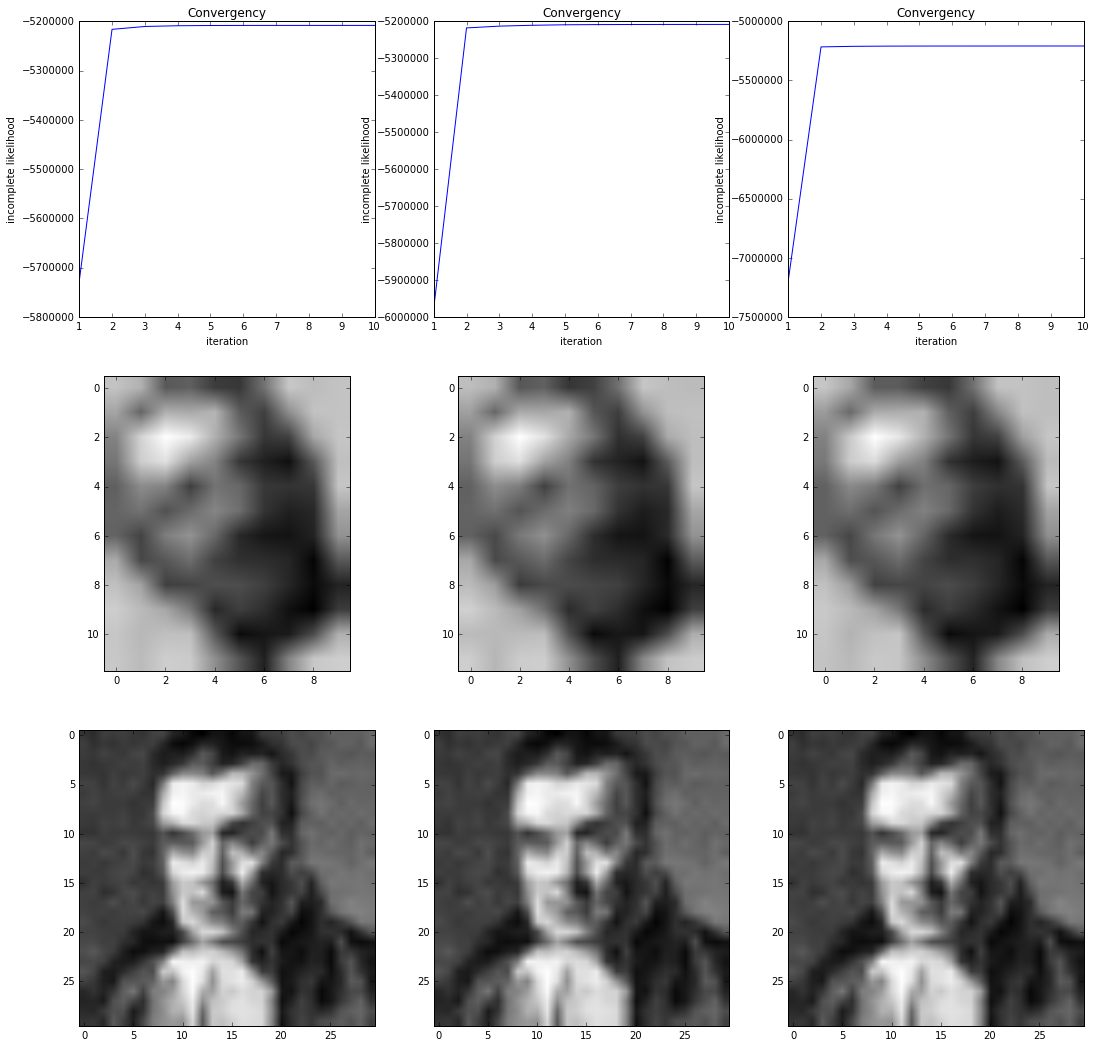

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(18,18))

for i in xrange(3):
    axes[0, i].plot(Lls[i])
    axes[0, i].set_xlabel("iteration")
    axes[0, i].set_ylabel("incomplete likelihood")
    axes[0, i].set_title("Convergency")
    axes[1, i].imshow(Fs[i], cmap="gray")
    axes[2, i].imshow(Bs[i], cmap="gray")

With appropriate number of iterations our EM-algorithm converges to the same results regardless of random initialization. So there is no need to run it several times.<br/>Moreover there are quite elegant ways to obtain good initialization values for all variables instead of using random values (they will be discussed further).

# 2. Size and noise robustness.

In [5]:
Nsizes = [200, 400, 600, 800, 1000]
Nlls = []

for i in xrange(len(Nsizes)):
    pics = Generate("bayes.png", (30, 30), "face.png", (12, 10), Nsizes[i], 100)
    detective = VillainEM(max_iter=10, h=12, w=10)
    detective.fit(pics)
    Nlls.append(detective.log_ll[-1]/Nsizes[i]/30/30)

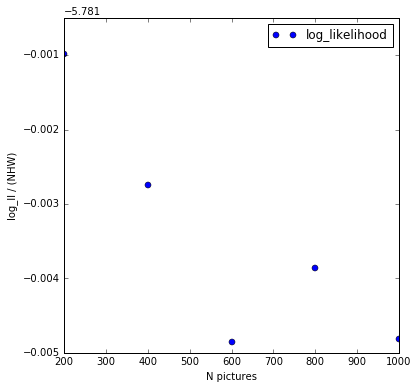

In [6]:
plt.figure(figsize=(6,6))
plt.plot(Nsizes, Nlls, "o", label="log_likelihood")
plt.legend(loc="best")
plt.xlabel("N pictures")
plt.ylabel("log_ll / (NHW)")

In [7]:
Bsizes = [20, 25, 30, 35, 40]
Blls = []

for i in xrange(len(Bsizes)):
    pics = Generate("bayes.png", (Bsizes[i], Bsizes[i]), "face.png", (12, 10), 1000, 100)
    detective = VillainEM(max_iter=10, h=12, w=10)
    detective.fit(pics)
    Blls.append(detective.log_ll[-1]/1000/Bsizes[i]/Bsizes[i])

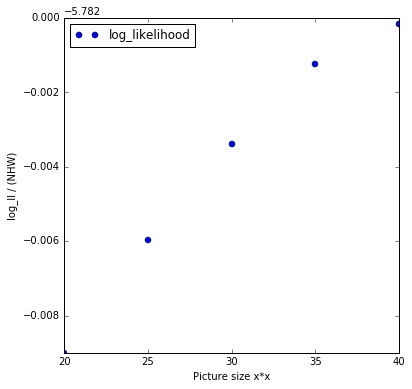

In [8]:
plt.figure(figsize=(6,6))
plt.plot(Bsizes, Blls, "o", label="log_likelihood")
plt.legend(loc="best")
plt.xlabel("Picture size x*x")
plt.ylabel("log_ll / (NHW)")

In [9]:
Fsizes = [8, 10, 12, 14, 16]
Flls = []

for i in xrange(len(Fsizes)):
    pics = Generate("bayes.png", (30, 30), "face.png", (np.int32(1.2*Fsizes[i]), Fsizes[i]), 1000, 100)
    detective = VillainEM(max_iter=10, h=np.int32(1.2*Fsizes[i]), w=Fsizes[i])
    detective.fit(pics)
    Flls.append(detective.log_ll[-1]/1000/30/30)

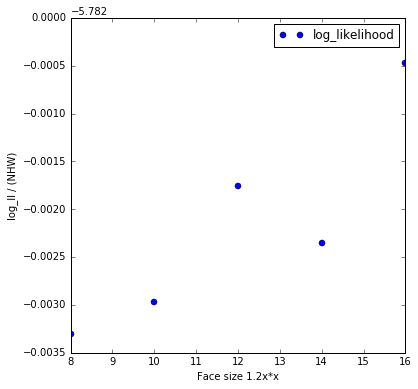

In [10]:
plt.figure(figsize=(6,6))
plt.plot(Fsizes, Flls, "o", label="log_likelihood")
plt.legend(loc="best")
plt.xlabel("Face size 1.2x*x")
plt.ylabel("log_ll / (NHW)")

In [11]:
Sgms = [50, 100, 150, 200, 250]
Bs = []
Fs = []
lls = []

for i in xrange(len(Sgms)):
    pics = Generate("bayes.png", (30, 30), "face.png", (12, 10), 1000, Sgms[i])
    detective = VillainEM(max_iter=10, h=12, w=10)
    detective.fit(pics)
    Bs.append(detective.B)
    Fs.append(detective.F)
    lls.append(detective.log_ll)

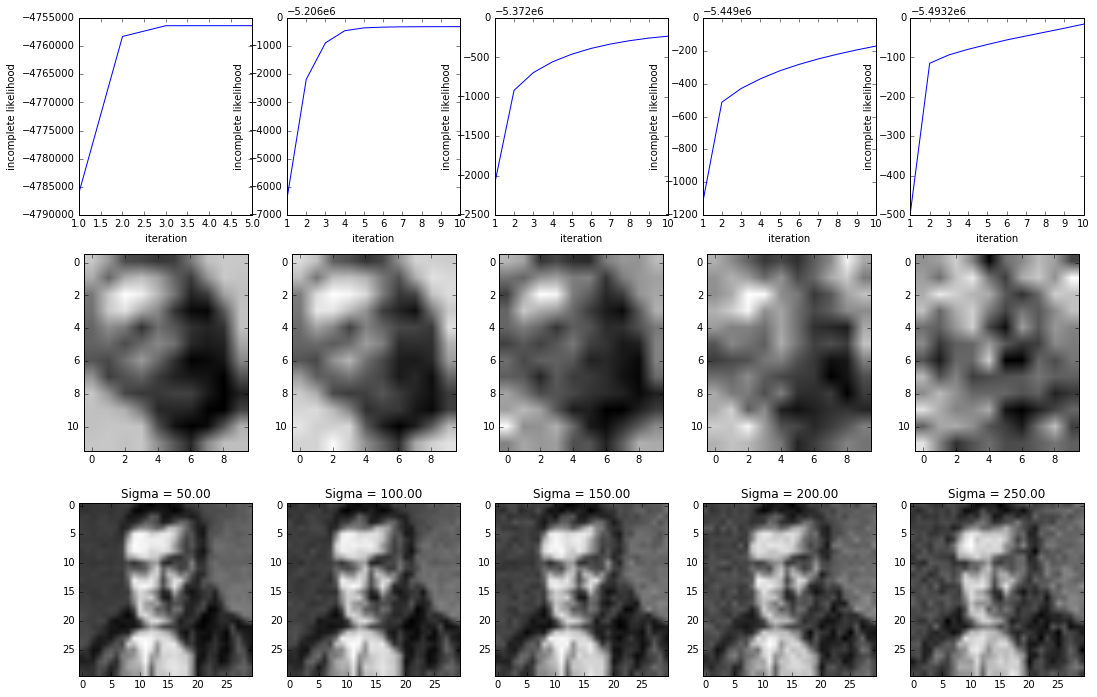

In [12]:
fig, axes = plt.subplots(3, 5, figsize=(18,12))

for i in xrange(5):
    axes[0, i].plot(lls[i])
    axes[0, i].set_xlabel("iteration")
    axes[0, i].set_ylabel("incomplete likelihood")
    axes[1, i].imshow(Fs[i], cmap="gray")
    axes[2, i].imshow(Bs[i], cmap="gray")
    axes[2, i].set_title("Sigma = %0.2f"%Sgms[i])

The more the sigma is, the more are pixels for which value became less than 0 or greater than 255. So our distribution stops being normal, so the algorithm stops working.

# 3. EM vs Hard-EM

In [13]:
pics = Generate("bayes.png", (30, 30), "face.png", (12, 10), 1000, 100)
EM = VillainEM(max_iter=10, h=12, w=10, hard=False)
HardEM = VillainEM(max_iter=10, h=12, w=10, hard=True)

In [14]:
%timeit -n1 -r1 EM.fit(pics)

1 loops, best of 1: 50.1 s per loop


In [15]:
%timeit -n1 -r1 HardEM.fit(pics)

1 loops, best of 1: 22.7 s per loop


villainEM.py:72: RuntimeWarning: divide by zero encountered in log
  log_gamma[pos_i, pos_j] = np.log(self.weights[pos_i, pos_j]) + log_pics.sum(axis=(0,1))


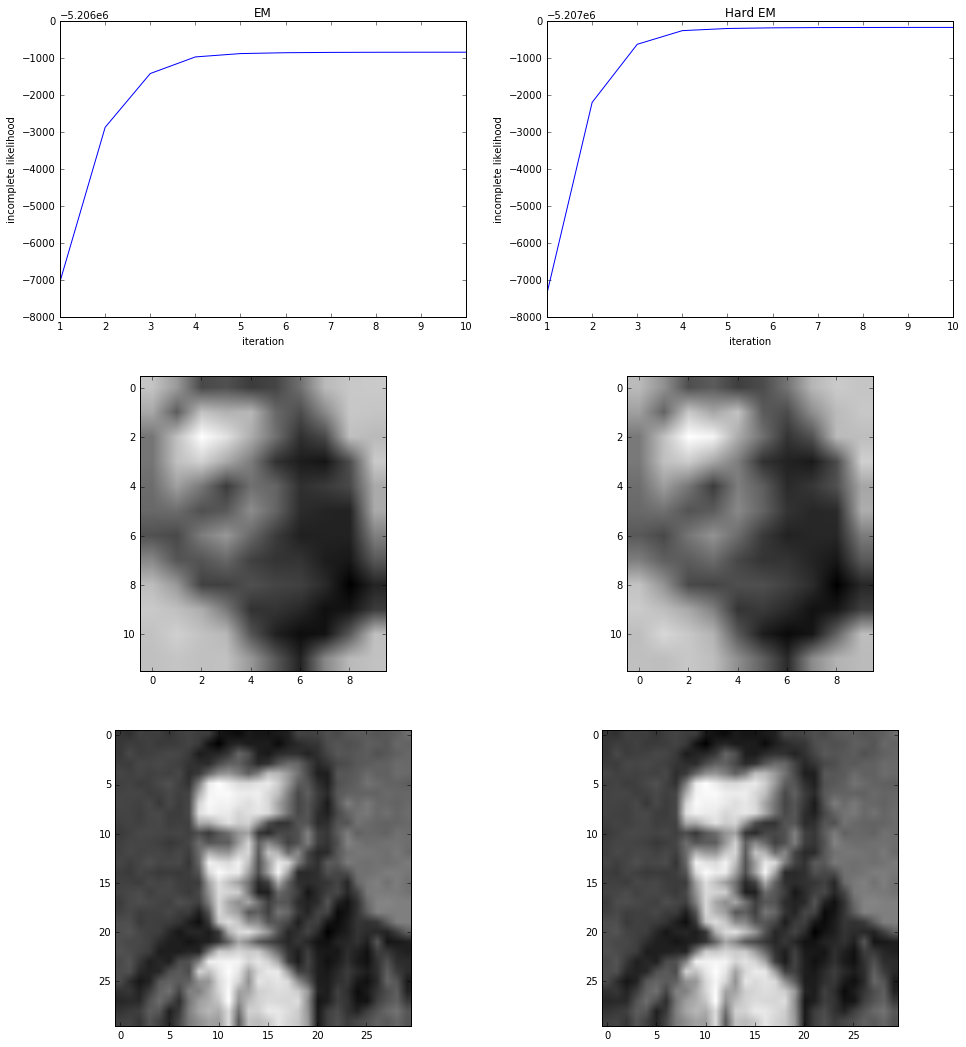

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

axes[0, 0].plot(EM.log_ll)
axes[0, 0].set_title("EM")
axes[0, 0].set_xlabel("iteration")
axes[0, 0].set_ylabel("incomplete likelihood")
axes[0, 1].plot(HardEM.log_ll)
axes[0, 1].set_title("Hard EM")
axes[0, 1].set_xlabel("iteration")
axes[0, 1].set_ylabel("incomplete likelihood")
axes[1, 0].imshow(EM.F, cmap="gray")
axes[1, 1].imshow(HardEM.F, cmap="gray")
axes[2, 0].imshow(EM.B, cmap="gray")
axes[2, 1].imshow(HardEM.B, cmap="gray")

# 4. Suspect identification

In [17]:
pics = np.load("../../../../Downloads/CameraData.npy")
EM = VillainEM(max_iter=5)
EM.fit(pics)

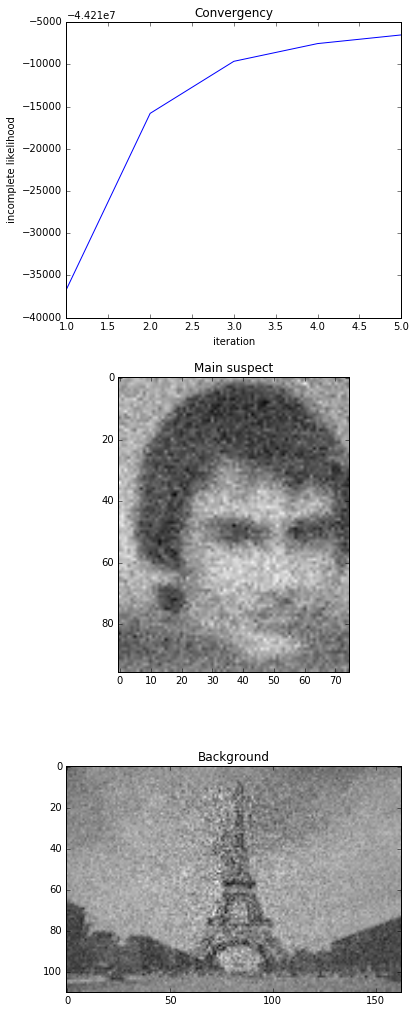

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(6, 18))

axes[0].plot(EM.log_ll, label="log_likelihood")
axes[0].set_title("Convergency")
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("incomplete likelihood")
axes[1].imshow(EM.F, cmap="gray")
axes[1].set_title("Main suspect")
axes[2].imshow(EM.B, cmap="gray")
axes[2].set_title("Background")

So, it actually needs a couple of iterations before convergency. The fact that it is dropping down is explained in the next section.

# 5. Bright ideas

#### Initialization
There are simple methods to get good initial values for all variables.

In [52]:
pics = np.load("../../../../Downloads/CameraData.npy")

H, W, N = pics.shape
h = 96
w = 75
dh = H - h + 1
dw = W - w + 1

Sigma = 115.619740604


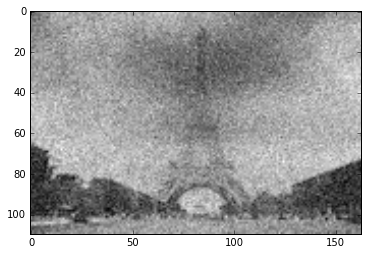

In [53]:
sigma = 0
mn = pics.mean(axis=2)
for i in xrange(N):
    sigma += ((pics[:, :, i] - mn)**2).sum()
print "Sigma =", np.sqrt(sigma/N/H/W)
plt.imshow(mn, cmap="gray")

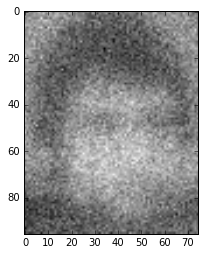

In [56]:
face = np.zeros((h, w))

for k in xrange(N):
    pic = pics[:, :, k] - mn
    dd = 0
    max_s = 0
    for d in xrange(dh*dw):
        pos_i = d/dw
        pos_j = d%dw
        s = np.fabs(pic[pos_i:pos_i+h, pos_j:pos_j+w].sum())
        if s > max_s:
            dd, max_s = d, s
    face += pics[dd/dw:dd/dw+h, dd%dw:dd%dw+w, k]
    
face = np.uint8(face/N)
plt.imshow(face, cmap="gray")

#### Fast probability computations

In the algorighm on every iteration we assume that face and background are actual pictures with every integer pixel value in range 0-255. Knowing that, we can precalculate table of probabilities of every pixel value to be in every position of the face and background picture. After that every configuration of probabilities can be produced bu intelligent slicing of that probabilities table. This method greatly speeds up E-step. The only drawback, that due to casting pictures to uint8 on every iteration there will be no complete convergency, but the algorithm will jump around optimal values (slight drops in lower bound value are possible).

#### Fixed B and $\sigma$

The original solution that was sent to Nick was found by incomplete EM, without learning background and $\sigma$ values.

#### W distribution

We defined our model with distribution over possible positions of the face picture. It helps when there are not many samples, because this distribution in that case is not uniform.<br/>But there is even more that you can do with this distribution. While computing probability distribution on latent variable, one can iterate not over all positions but on positions with nonzero (or nonsmall) probabilities of W. If W distribution is sparse this could speed up latent variable ditribution computations after a couple of iterations up to a number depending on sparsity coefficient. 